<a href="https://colab.research.google.com/github/alxkzncoff/skillfactory_rds6_car_price_prediction_ml_dl/blob/main/model/multi_input_nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# INSATLL

In [1]:
!pip install -q tensorflow==2.3
!mkdir work_dir

# DEFINE

In [75]:
DATA_PATH                           = '/content/work_dir'
RANDOM_SEED                         = 42

# IMPORT

In [76]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import PIL
import cv2
import re
import keras
import nltk
import codecs

# ml
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# keras
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [77]:
train = pd.read_csv(DATA_PATH+'/clear_train.csv')
test = pd.read_csv(DATA_PATH+'/clear_test.csv')
sample_submission = pd.read_csv(DATA_PATH+'/sample_submission.csv')
text_df = pd.concat([train.description, test.description])

# PREPARETION

In [78]:
def data_prep(TRAIN_DF, TEST_DF):

  # ################## Concat data ####################
  df = pd.concat([TRAIN_DF, TEST_DF])

  # ################## Tag data #####################
  df.price.fillna(0, inplace=True)
  df['sample'] = df.price.apply(lambda x:0 if x == 0 else 1)

  # ################## Prepare numeric data (Logarithm) ####################
  df.engine_displacement = df.engine_displacement.max() - np.log(df.engine_displacement)
  df.engine_power = df.engine_power.max() - np.log(df.engine_power)
  # df.model_date = df.model_date.max() - np.log(df.model_date)
  # df.production_date = df.production_date.max() - np.log(df.production_date)
  # df.days_in_use = df.days_in_use.max() - np.log(df.days_in_use)

  categorical_features = ['body', 'brand', 'color', 'fuel', 'model_info', 'name',  'num_of_doors',  'transmission', 'owners', 'vehicle_title', 'drive_type']
  numerical_features = ['engine_displacement', 'engine_power', 'mileage', 'model_date', 'production_date', 'tax', 'days_in_use']

  # ############################## Label Encoding #####################################
  for column in categorical_features:
      df[column] = df[column].astype('category').cat.codes
  
  # ############################### One Hot encoding ###################################
  df = pd.get_dummies(df, columns=categorical_features, dummy_na=False)

  # ############################### Normalization ######################################
  MMS = MinMaxScaler()

  MMS.fit(df[numerical_features])
  df[numerical_features] = MMS.transform(df[numerical_features])

  return df

In [79]:
df = data_prep(train, test)
df.head()

,description,engine_displacement,engine_power,mileage,model_date,price,production_date,tax,days_in_use,sample,body_0,body_1,body_2,body_3,body_4,body_5,body_6,body_7,body_8,body_9,body_10,body_11,body_12,brand_0,brand_1,brand_2,color_0,color_1,color_2,color_3,color_4,color_5,color_6,color_7,color_8,color_9,color_10,color_11,color_12,color_13,...,name_337,name_338,name_339,name_340,name_341,name_342,name_343,name_344,name_345,name_346,name_347,name_348,name_349,name_350,name_351,name_352,name_353,name_354,name_355,name_356,name_357,name_358,name_359,num_of_doors_0,num_of_doors_1,num_of_doors_2,num_of_doors_3,transmission_0,transmission_1,transmission_2,transmission_3,owners_0,owners_1,owners_2,owners_3,vehicle_title_0,vehicle_title_1,drive_type_0,drive_type_1,drive_type_2
0,Авто на бодром ходу. Все работает отлично. П...,0.328812,0.423210,0.244999,0.750000,599000.0,0.657895,0.383285,0.342100,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,1
1,"Продажа от собственника, второй владелец, ПТС ...",0.357585,0.552008,0.182999,0.833333,850000.0,0.763158,0.118732,0.236833,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,1,0
2,Внимание! Только для клиентов AVILON Автомобил...,0.264526,0.370477,0.122732,0.791667,1325000.0,0.815789,0.432277,0.184163,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,1
3,В комплекте зимние колёса. 27.07.2020 Замена п...,0.497904,0.608045,0.150999,0.833333,815000.0,0.763158,0.077810,0.236833,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,1,0
4,"Отличный авто, 2011 года выпуска, кроме передн...",0.541843,0.660777,0.139999,0.750000,810000.0,0.763158,0.060519,0.236833,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,1,0


In [80]:
text_df

0       Авто на бодром ходу.  Все работает отлично.  П...
1       Продажа от собственника, второй владелец, ПТС ...
2       Внимание! Только для клиентов AVILON Автомобил...
3       В комплекте зимние колёса. 27.07.2020 Замена п...
4       Отличный авто, 2011 года выпуска, кроме передн...
                              ...                        
1666    Продаётся любимица семьи. Автомобилем неактивн...
1667    В продаже автомобиль от компании АО ABTODOM, о...
1668    Машина в идеальном техническом состоянии. Обсл...
1669    Автомобиль приобретался новым у дилера Avilon ...
1670    ID: 38887\nКомплектация-Comfort\nГод выпуска в...
Name: description, Length: 8353, dtype: object

# TO DO LIST

1. Удалить все нерелевантные символы (например, любые символы, не относящиеся к цифро-буквенным).
2. Токенизировать текст, разделив его на индивидуальные слова.
3. Удалить нерелевантные слова — например, упоминания в Twitter или URL-ы.
4. Перевести все символы в нижний регистр для того, чтобы слова «привет», «Привет» и «ПРИВЕТ» считались одним и тем же словом.
5. Рассмотрите возможность совмещения слов, написанных с ошибками, или имеющих альтернативное написание (например, «круто»/«круть»/ «круууто»)
6. Рассмотрите возможность проведения лемматизации, т. е. сведения различных форм одного слова к словарной форме (например, «машина» вместо «машиной», «на машине», «машинах» и пр.)

# CLEAN DATA

In [81]:
text_df = text_df.str.lower()

# SPLIT

In [82]:
X = df.query('sample==1').drop(columns=['description', 'price', 'sample'])
y = df.query('sample==1').price.values
test = df.query('sample==0').drop(columns=['description', 'price', 'sample'])

# ############ Split #################
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

text_train = text_df.iloc[X_train.index]
text_test = text_df.iloc[X_test.index]
text_sub = text_df.iloc[test.index]

# TOKENIZE

In [83]:
# The maximum number of words to be used. (most frequent)
MAX_WORDS = 100000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 256

In [84]:
%%time
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(text_df)

CPU times: user 1.29 s, sys: 0 ns, total: 1.29 s
Wall time: 1.29 s


In [85]:
tokenize.word_index

{'•': 1,
 'в': 2,
 'и': 3,
 'с': 4,
 'на': 5,
 'не': 6,
 'по': 7,
 'система': 8,
 'автомобиль': 9,
 'все': 10,
 'для': 11,
 'автомобиля': 12,
 'от': 13,
 'до': 14,
 'при': 15,
 'у': 16,
 'пробегом': 17,
 '2': 18,
 'состоянии': 19,
 'без': 20,
 'авто': 21,
 'салон': 22,
 'пакет': 23,
 'за': 24,
 'машина': 25,
 'автомобилей': 26,
 'сидений': 27,
 'птс': 28,
 'безопасности': 29,
 'то': 30,
 'bmw': 31,
 'из': 32,
 'более': 33,
 '000': 34,
 'автомобили': 35,
 'водителя': 36,
 'комплектация': 37,
 'есть': 38,
 '1': 39,
 'года': 40,
 'комплект': 41,
 'сиденья': 42,
 'только': 43,
 'дилера': 44,
 'салона': 45,
 'пробег': 46,
 'контроль': 47,
 'фары': 48,
 '6': 49,
 'кредит': 50,
 'диски': 51,
 'лет': 52,
 'передние': 53,
 '3': 54,
 'руля': 55,
 'датчик': 56,
 'пассажира': 57,
 'км': 58,
 'оригинал': 59,
 'подушки': 60,
 'а': 61,
 'мы': 62,
 '9': 63,
 'подогрев': 64,
 'состояние': 65,
 'заднего': 66,
 'вас': 67,
 '5': 68,
 'обслуживание': 69,
 'зеркал': 70,
 '–': 71,
 'торг': 72,
 'дтп': 73,
 '

In [86]:
%%time
text_train_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_train), maxlen=MAX_SEQUENCE_LENGTH)
text_test_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_test), maxlen=MAX_SEQUENCE_LENGTH)
text_sub_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_sub), maxlen=MAX_SEQUENCE_LENGTH)

print(text_train_sequences.shape, text_test_sequences.shape, text_sub_sequences.shape, )

(5679, 256) (1003, 256) (1671, 256)
CPU times: user 1.16 s, sys: 0 ns, total: 1.16 s
Wall time: 1.16 s


In [87]:
print(text_train.iloc[100])
print(text_train_sequences[100])

«inchcape certified-  первый международный официальный гипермаркет автомобилей с пробегом и
официальный дилер bmw,mini, land rover, jaguar, toyota, lexus, mitsubishi, hyundai, volvo и infiniti
уникальные условия покупки автомобиля с пробегом в inchcape certified:
-при обмене на ваш автомобиль и покупке в кредит от 10,9%. одобрение в течении 1 час по двум документам.
-выгодные условия выкупа вашего автомобиля. получение 100% суммы из кассы в течение 1часа!
-автомобиль полностью проверен по технической и кузовной части, критических недостатков не выявлено.
-успешно пройдена криминалистическая проверка. гарантия юридической чистоты.

автомобиль принят по системе trade-in в обмен на новый!

особые условия на представленный автомобиль для вас при покупке в кредит или обмене

комплектация:
• антиблокировочная система
• система курсовой устойчивости
• датчик усталости водителя
• датчик давления в шинах
• подушки безопасности водителя
• подушки безопасности пассажира
• боковые передние подушки

# MODEL

In [88]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [90]:
def build_model(LR, EPOCHS, OPTIMIZER_TYPE):

  # ################## NLP model ####################
  model_nlp = Sequential()
  model_nlp.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))
  model_nlp.add(L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,))
  model_nlp.add(L.LSTM(256, return_sequences=True))
  model_nlp.add(L.Dropout(0.5))
  model_nlp.add(L.LSTM(128,))
  model_nlp.add(L.Dropout(0.25))
  model_nlp.add(L.Dense(64, activation="relu"))
  model_nlp.add(L.Dropout(0.25))

  # ################# Create simple neural network ####################
  model_mlp = Sequential()
  model_mlp.add(L.Dense(128, input_dim=X_train.shape[1], activation="relu"))
  model_mlp.add(L.Dropout(0.1))
  model_mlp.add(L.Dense(64, activation="relu"))
  model_mlp.add(L.Dropout(0.1))
  model_mlp.add(L.Dense(1, activation="linear"))

  # ################# Concat models ######################
  combinedInput = L.concatenate([model_nlp.output, model_mlp.output])
  head = L.Dense(64, activation="relu")(combinedInput)
  head = L.Dense(1, activation="linear")(head)

  model = Model(inputs=[model_nlp.input, model_mlp.input], outputs=head)

  display(model.summary())

  # ################# Optimizer #######################
  if OPTIMIZER_TYPE == 'Adam':
    optimizer = tf.keras.optimizers.Adamax(LR)
  elif OPTIMIZER_TYPE == 'Adamax':
    optimizer = tf.keras.optimizers.Adamax(LR)

  model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

  # ################# Checkpoints ######################
  checkpoint = ModelCheckpoint(DATA_PATH+'/best_model.hdf5' , monitor=['val_MAPE'], verbose=0  , mode='min')
  earlystop = EarlyStopping(monitor='val_MAPE', patience=50, restore_best_weights=True,)
  callbacks_list = [checkpoint, earlystop]

  # ######################## Fit model ##############################
  history = model.fit([text_train_sequences, X_train], y_train,
                    batch_size=512,
                    epochs=1000, 
                    validation_data=([text_test_sequences, X_test], y_test),
                    callbacks=callbacks_list,
                    verbose=0
                   )
  
  # ######################## Saving best model #####################
  model.load_weights(DATA_PATH+'/best_model.hdf5')
  model.save(DATA_PATH+'/nn_mlp_nlp.hdf5')

  # ######################## Show results ###########################
  plt.figure(figsize=(15,10))
  plt.title('Loss')
  plt.plot(history.history['MAPE'], label='train')
  plt.plot(history.history['val_MAPE'], label='test')
  plt.legend()
  plt.grid()
  plt.show()

  test_predict_nn2 = model.predict([text_test_sequences, X_test])
  print(f"TEST mape: {(mape(y_test, test_predict_nn2[:,0]))*100:0.2f}%")

  return model, checkpoint, earlystop, callbacks_list, history

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_description (InputLayer)    [(None, 256)]        0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 256, 256)     10135552    seq_description[0][0]            
__________________________________________________________________________________________________
lstm_8 (LSTM)                   (None, 256, 256)     525312      embedding_4[0][0]                
__________________________________________________________________________________________________
dense_21_input (InputLayer)     [(None, 542)]        0                                            
_______________________________________________________________________________________

None

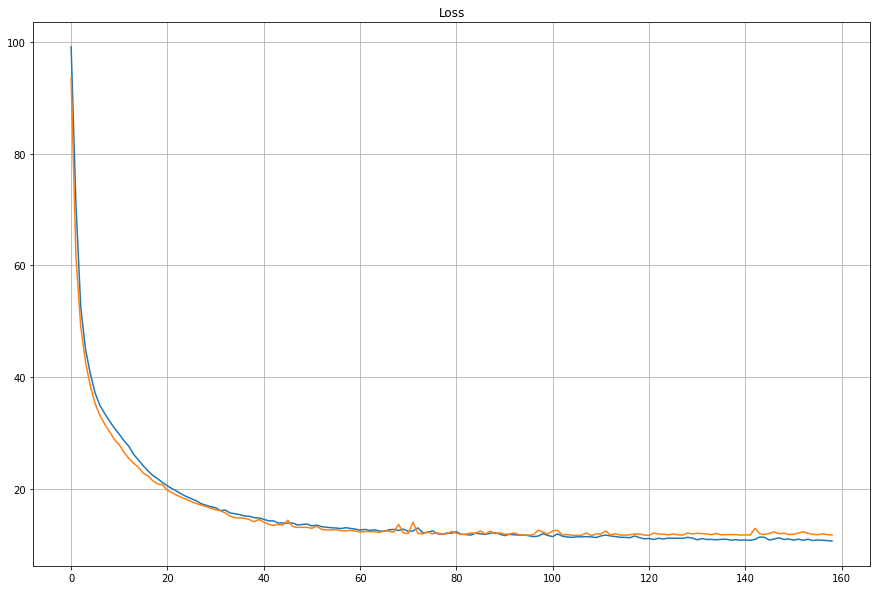

TEST mape: 11.66%


In [91]:
model, checkpoint, earlystop, callbacks_list, history = build_model(LR=0.1, EPOCHS=1000, OPTIMIZER_TYPE='Adamax')

# PREDICT

In [93]:
predict_submission = model.predict([text_sub_sequences, test])

sample_submission['price'] = predict_submission
sample_submission.to_csv(DATA_PATH+'/sub_nn2.csv', index=False)
display(sample_submission.head(10))

,sell_id,price
0,1099427284,5.957154e+05
1,1096405886,2.614964e+06
2,1100195294,6.481189e+05
3,1099827282,5.184060e+05
4,1100076198,2.725332e+06
5,1090159352,3.100224e+06
6,1098987386,1.681741e+06
7,1098639040,1.494656e+06
8,1099933039,1.118091e+06
9,1099565572,5.166018e+05
